In [12]:
import os, io, shutil
import time
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch import topk
from tqdm.autonotebook import tqdm

import numpy as np
from tensorboardX import SummaryWriter
from dataloader.dataset import VideoDataset

import sys
sys.path.append('./src/pytorch-lr-finder')
sys.path.append('./src/kinetics_i3d_pytorch/src')
from lr_finder import LRFinder

In [13]:
model_name = 'i3d'
img_size = 256
crop_size = 224
batch_size = 1
frame_nb = 16
num_classes = 2

transform = transforms.Compose([
        transforms.Resize((crop_size, crop_size)), # bilinear
        transforms.ToTensor(), #ndarray => torch.FloatTensor [0.0, 1.0].
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [-1.0, 1.0]
    ])

data_name = 'anesthesia'
dataset_path = os.getcwd()
dataset = {
    'train':VideoDataset(dataset_path, clip_len=16, split='train', transform=transform),
    'val':VideoDataset(dataset_path, clip_len=16, split='val', transform=transform),
    'test':VideoDataset(dataset_path, clip_len=16, split='test', transform=transform)
}

Number of /data/private/minjee-video/handhygiene/images/train videos: 2402
Number of /data/private/minjee-video/handhygiene/images/val videos: 212
Number of /data/private/minjee-video/handhygiene/images/test videos: 175


# check optical flows

In [3]:
#for phase in ['train', 'val', 'test']:
#    for i in tqdm(range(dataset[phase].__len__())):
#        dataset[phase].__getitem__(i)

In [21]:
flow = dataset['train'].__getitem__(0)[1]

In [66]:
import imageio
def generate_gif_from_npy(npy):
    """
        argument: (npyfile): .npy file of flow array
    """
    images = []
    for image in npy.transpose(0, 1):
        image = np.asarray(((image + 1)/2)*255, dtype=np.uint8).transpose(1, 2, 0)
        #print(image)
        shape = image.shape
        ch3 = np.ones((shape[0], shape[1], 1), dtype=np.uint8)*128
        images.append(np.dstack((image, ch3)))
    dirname = os.path.dirname('/data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000113/')
    basename = os.path.basename(dirname)
    dstname = '{}_flow_16.gif'.format(basename)
    imageio.mimsave(os.path.join(dirname, dstname), images)

In [67]:
generate_gif_from_npy(flow)

In [19]:
for i in range(dataset['train'].__len__()):
    print(i, dataset['train'].__getpath__(i))

0 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000113
1 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000160
2 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000187
3 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000213
4 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000247
5 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000312
6 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000431
7 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000643
8 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000699
9 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000740
10 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000778
11 /data/private/minjee-video/handhygiene/images/train/clean/38_

707 /data/private/minjee-video/handhygiene/images/train/clean/18_20181204_frames006385
708 /data/private/minjee-video/handhygiene/images/train/clean/1_20180806_frames001060
709 /data/private/minjee-video/handhygiene/images/train/clean/1_20180806_frames001118
710 /data/private/minjee-video/handhygiene/images/train/clean/1_20180806_frames001191
711 /data/private/minjee-video/handhygiene/images/train/clean/1_20180806_frames001229
712 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000270
713 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000300
714 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000382
715 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000447
716 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000538
717 /data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames000564
718 /data/private/minjee-video/handhygiene/imag

1457 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames002538_1
1458 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames002538_16
1459 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames002538_4
1460 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames002538_20
1461 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames002538_15
1462 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames003810_0
1463 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames003810_14
1464 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames003810_15
1465 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames003810_1
1466 /data/private/minjee-video/handhygiene/images/train/notclean/38_20190119_frames003810_17
1467 /data/private/minjee-video/handhygiene/images/train/notclea

In [68]:
for i in range(dataset['val'].__len__()):
    print(i, dataset['val'].__getpath__(i))

0 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames012203
1 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames063984
2 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames064016
3 /data/private/minjee-video/handhygiene/images/val/clean/8_20181122_frames001291
4 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames012203_2
5 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames012203_4
6 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames012203_1
7 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames063984_1
8 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames063984_3
9 /data/private/minjee-video/handhygiene/images/val/clean/17_20181203_frames063984_2
10 /data/private/minjee-video/handhygiene/images/val/clean/8_20181122_frames001291_11
11 /data/private/minjee-video/handhygiene/images/val/clean/8_20181122_fra

In [69]:
for i in range(dataset['test'].__len__()):
    print(i, dataset['test'].__getpath__(i))

0 /data/private/minjee-video/handhygiene/images/test/clean/28_20181226_frames023555
1 /data/private/minjee-video/handhygiene/images/test/clean/5_20181119_frames094950
2 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808
3 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_0
4 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_2
5 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_10
6 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_12
7 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_20
8 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_18
9 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_22
10 /data/private/minjee-video/handhygiene/images/test/clean/13_20181129_frames000808_5
11 /data/private/minjee-video/handhygiene/images/test/c

In [3]:
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=True, num_workers=8),
    'test': DataLoader(dataset['test'], batch_size=batch_size, shuffle=True, num_workers=8)
}

# Visualization of Dataset

In [4]:
import matplotlib.pyplot as plt
def show_dataset(item): # item: N x 3 x 244 x 244
    rgbs = item[0]
    flows = item[1]
    n = len(item[0])
    
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)
    img = np.vstack((rgb, flow))
    plt.figure(figsize=(100, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

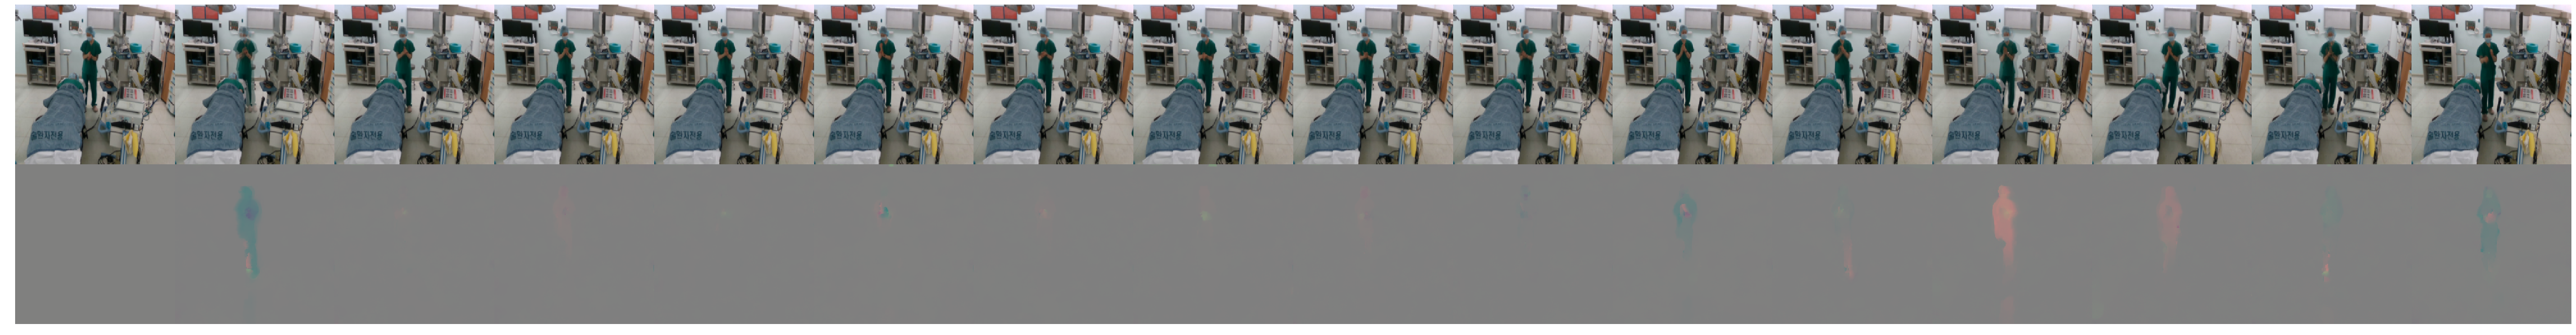

In [58]:
show_dataset(dataset['train'].__getitem__(0))

# Train 

In [4]:
from i3dpt import I3D, Unit3Dpy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
import copy

model_name = 'i3d'
logpath = os.path.join('./logs/', model_name)
if not os.path.exists(logpath): os.mkdir(logpath)
writer = SummaryWriter(logpath)


i3d_model_path = './src/kinetics_i3d_pytorch/'
sys.path.append(i3d_model_path)
rgb_weights_path = i3d_model_path+'model/model_rgb.pth'
flow_weights_path = i3d_model_path+'model/model_flow.pth'
frame_nb = 16
im_size= 224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def modify_last_layer(out_channels):
    return Unit3Dpy(in_channels=1024, out_channels=out_channels, kernel_size=(1, 1, 1),
            activation=None, use_bias=True, use_bn=False)

In [6]:
i3d_rgb = I3D(num_classes=400, modality='rgb')
i3d_rgb.load_state_dict(torch.load(rgb_weights_path))
i3d_rgb.conv3d_0c_1x1 = modify_last_layer(out_channels=num_classes)
#i3d_rgb.softmax = torch.nn.Sigmoid()
i3d_rgb.to(device)

i3d_flow = I3D(num_classes=400, modality='flow')
i3d_flow.load_state_dict(torch.load(flow_weights_path))
i3d_flow.conv3d_0c_1x1 = modify_last_layer(out_channels=num_classes)
#i3d_flow.softmax = torch.nn.Sigmoid()
i3d_flow.to(device)

I3D(
  (conv3d_1a_7x7): Unit3Dpy(
    (pad): ConstantPad3d(padding=(2, 3, 2, 3, 2, 3), value=0)
    (conv3d): Conv3d(2, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), bias=False)
    (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxPool3d_2a_3x3): MaxPool3dTFPadding(
    (pad): ConstantPad3d(padding=(0, 1, 0, 1, 0, 0), value=0)
    (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=True)
  )
  (conv3d_2b_1x1): Unit3Dpy(
    (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3d_2c_3x3): Unit3Dpy(
    (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (batch3d): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxPool3d_3a_3x3): MaxPool3dTFPadding(
    (pad): ConstantPad3d(paddin

In [7]:
criterion = F.cross_entropy
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-7)
#lr_finder = LRFinder(model, optimizer, criterion, modality='rgb', device="cuda")
#lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=1000, step_mode="exp")
#lr_finder.plot()
def optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-7)
#optimizer(i3d_rgb)
#optimizer(i3d_flow)

In [8]:
# train by epoch
def train(dataloders, optimizer, frame_nb=16, num_epochs=50): # 
    since = time.time()
    best_model_wts = {'rgb':i3d_rgb.state_dict(), 'flow':i3d_flow.state_dict()}
    best_acc = 0.0
    iterations = {'train': 0, 'valid': 0}
    
    for epoch in tqdm(range(num_epochs)):
        
        for phase in ['train', 'val']:
            if phase == 'train':
                i3d_rgb.train()
            else:
                i3d_rgb.eval()

            running_loss = 0.0
            running_corrects = {'rgb':0, 'flow':0, 'joint':0}
            
            for i, (samples) in enumerate(dataloders[phase]):
                rgbs = samples[0] #BCDHW
                flows = samples[1]
                targets = samples[2]
                
                #print(rgbs.shape, flows.shape, targets.shape)
                ##### rgb model
                optimizer(i3d_rgb).zero_grad()
                rgbs = Variable(rgbs.to(device))
                targets = Variable(targets.to(device))
                
                rgb_out_vars, rgb_out_logits = i3d_rgb(rgbs)
                _, rgb_preds = torch.max(rgb_out_vars.data, 1)
                
                #print(rgb_out_vars.shape, rgb_preds.shape)
                ##### flow model
                optimizer(i3d_flow).zero_grad()
                flows = Variable(flows.to(device))
                
                flow_out_vars, flow_out_logits = i3d_flow(flows)
                _, flow_preds = torch.max(flow_out_vars.data, 1)
                
                #print(flow_out_vars.shape, flow_preds.shape)
                ##### joint model
                out_logit = rgb_out_logits + flow_out_logits
                # for softmax model
                out_softmax = torch.nn.functional.softmax(out_logit, 1)
                _, out_preds = torch.max(out_softmax, 1)
                out_loss = criterion(out_softmax, targets.view(-1)).to(device)
                
                # for sigmoid
                #out_sigmoid = torch.sigmoid(out_logit)
                #_, out_preds = torch.max(out_sigmoid, 1)
                #out_loss= criterion(out_sigmoid, targets).to(device)
                #print(out_sigmoid.shape, out_preds.shape)
                
                #targets_onenode= torch.max(targets, 1)[1]
                running_loss += out_loss.item() * rgbs.size(0)
                running_corrects['rgb'] += torch.sum(rgb_preds.to(device) == targets.to(device)) / rgbs.size(0)
                running_corrects['flow'] += torch.sum(flow_preds.to(device) == targets.to(device)) / rgbs.size(0)
                running_corrects['joint'] += torch.sum(out_preds.to(device) == targets.to(device)) / rgbs.size(0)

                del rgbs, flows, out_softmax, out_loss
                torch.cuda.empty_cache()
            
            ## for plotting 
            # per epoch
            if phase == 'train':
                train_epoch_loss = running_loss / len(dataloaders[phase].dataset)
                train_epoch_rgb_acc = running_corrects['rgb'].double()  / len(dataloaders[phase].dataset)
                train_epoch_flow_acc = running_corrects['flow'].double()  / len(dataloaders[phase].dataset)
                train_epoch_joint_acc = running_corrects['joint'].double()  / len(dataloaders[phase].dataset)
                    
            else:
                valid_epoch_loss = running_loss / len(dataloaders[phase].dataset)
                valid_epoch_rgb_acc = running_corrects['rgb'].double() / len(dataloaders[phase].dataset)
                valid_epoch_flow_acc = running_corrects['flow'].double() / len(dataloaders[phase].dataset)
                valid_epoch_joint_acc = running_corrects['joint'].double()  / len(dataloaders[phase].dataset)
            
            # deep copy best model
            if phase == 'val' and valid_epoch_joint_acc > best_acc:
                best_acc = valid_epoch_joint_acc
                best_model_rgb_wts = copy.deepcopy(i3d_rgb.state_dict())
                best_model_flow_wts = copy.deepcopy(i3d_flow.state_dict())
                best_iters = iterations['train']
                
        writer.add_scalars('Loss', {'training': train_epoch_loss, 
                                    'validation': valid_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'training_rgb': train_epoch_rgb_acc, 
                                        'training_flow': train_epoch_flow_acc,
                                        'training_joint': train_epoch_joint_acc,
                                        'validation_rgb': valid_epoch_rgb_acc,
                                        'validation_flow': valid_epoch_flow_acc,
                                        'validation_joint': valid_epoch_joint_acc}, epoch)
        
        torch.save(i3d_rgb.state_dict(), 
               os.path.join('./weights/{}_{}_epoch_{}.pth'.format('handhygiene', 'i3d_rgb', epoch)))
        torch.save(i3d_flow.state_dict(), 
               os.path.join('./weights/{}_{}_epoch_{}.pth'.format('handhygiene', 'i3d_flow', epoch)))
    
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        train_epoch_loss, train_epoch_joint_acc, 
                        valid_epoch_loss, valid_epoch_joint_acc))
        
    print('Best val Acc: {:4f}'.format(best_acc))

    i3d_rgb.load_state_dict(best_model_rgb_wts)
    i3d_flow.load_state_dict(best_model_flow_wts)
    torch.save(i3d_rgb.state_dict(), 
               os.path.join('./weights/{}_{}_bestiters_{}.pth'.format('handhygiene', 'i3d_rgb', best_iters)))
    torch.save(i3d_flow.state_dict(), 
               os.path.join('./weights/{}_{}_bestiters_{}.pth'.format('handhygiene', 'i3d_flow', best_iters)))
    writer.close()
    return i3d_rgb, i3d_flow

In [9]:
train(dataloaders, optimizer,  num_epochs=100)

Epoch [0/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6974 acc: 0.4615
Epoch [1/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6989 acc: 0.4872
Epoch [2/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6954 acc: 0.5128
Epoch [3/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6887 acc: 0.6282
Epoch [4/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6928 acc: 0.5641
Epoch [5/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6925 acc: 0.5641
Epoch [6/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6967 acc: 0.5256
Epoch [7/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6957 acc: 0.4744
Epoch [8/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6985 acc: 0.5000
Epoch [9/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6942 acc: 0.5641
Epoch [10/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6966 acc: 0.5128
Epoch [11/99] train loss: 0.6934 acc: 0.4932 valid loss: 0.6880 acc: 0.5897


KeyboardInterrupt: 